In [26]:
import keras
#from PIL import Image
from keras import layers
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
#from PIL import Image
from keras.utils import to_categorical
import random
from keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.cm as cm

In [27]:
model = keras.models.load_model("./model/model_CNN_20240316t2029.h5")

In [28]:
def get_img_array(img_paths,target_size):
    img = keras.utils.load_img(img_paths,target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array,axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

In [57]:
img_path = './151.jpg'
img_array = get_img_array(img_path,target_size=(128,128))


In [58]:
print(img_path)

./151.jpg


In [59]:
preds = model.predict(img_array)
print(preds)
print("insulting", preds[0][1])
print("uninsulting", preds[0][0])

1/1 [==============================] - 0s 18ms/step
[[0.67884475 0.31843752]]
insulting 0.31843752
uninsulting 0.67884475


In [17]:
np.argmax(preds[0])

0

In [18]:
last_conv_layer_name = "conv2d_37"
classifier_layer_names = [
    "max_pooling2d_31",
    "flatten_7",
    "dense_7"
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs,last_conv_layer.output)

In [19]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    print("1")
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input,x)
classifier_model.summary()

1
1
1
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 12, 64)]      0         
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 2304)              0         
                                                                 
 dense_7 (Dense)             (None, 2)                 4610      
                                                                 
Total params: 4610 (18.01 KB)
Trainable params: 4610 (18.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
with tf.GradientTape() as tape:
    # 设置tape监视模型最后一个卷积层的输出
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    
    # 通过模型获取预测结果
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    # 提取我们感兴趣的类别的输出
    top_class_channel = preds[:, top_pred_index]

# 现在使用GradientTape.gradient方法来计算相对于最后一个卷积层输出的梯度
grads = tape.gradient(top_class_channel, last_conv_layer_output)



In [21]:
# 接下来的步骤（如池化梯度和生成热图）与之前相同
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i]*=pooled_grads[i]
heatmap = np.mean(last_conv_layer_output,axis=-1)

[[1.7773302e-05 1.7743017e-05 1.7692413e-05 1.7558992e-05 1.7481952e-05
  1.7474318e-05 1.7503386e-05 1.7637039e-05 1.7827679e-05 1.8013316e-05
  1.8066903e-05 1.8103759e-05]
 [1.8140057e-05 1.8084664e-05 1.7979166e-05 1.7704418e-05 1.7495142e-05
  1.7516839e-05 1.7564094e-05 1.7667529e-05 1.7834529e-05 1.8013268e-05
  1.8080264e-05 1.8125014e-05]
 [1.8011264e-05 1.8281007e-05 1.8177312e-05 1.7973531e-05 1.7642451e-05
  1.7602282e-05 1.7649392e-05 1.7705212e-05 1.7853583e-05 1.8038441e-05
  1.8121656e-05 1.8197989e-05]
 [1.7961780e-05 1.8148245e-05 1.8117671e-05 1.8026725e-05 1.7835335e-05
  1.7706436e-05 1.7790942e-05 1.7758994e-05 1.7843504e-05 1.8045999e-05
  1.8133847e-05 1.8207240e-05]
 [1.7801758e-05 1.7982247e-05 1.8059525e-05 1.8053763e-05 1.7995842e-05
  1.7812939e-05 1.7851748e-05 1.7861361e-05 1.7850925e-05 1.7998767e-05
  1.8157698e-05 1.8207154e-05]
 [1.7586137e-05 1.7759299e-05 1.7968499e-05 1.8033446e-05 1.8025587e-05
  1.7911903e-05 1.7860109e-05 1.7942397e-05 1.7949762

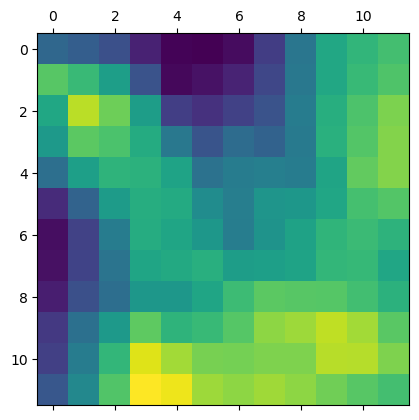

In [23]:
K = 0.05
heatmap = np.maximum(heatmap,0)
print(heatmap)
heatmap /= np.max(heatmap)
heatmap -= 1-K
heatmap *= 1 / K
plt.matshow(heatmap)

In [24]:
heatmap_1 = heatmap

[[0.34584284 0.3128791  0.25779843 0.11257172 0.02871633 0.02040625
  0.05204558 0.19752502 0.40503144 0.6070936  0.6654215  0.705539  ]
 [0.7450485  0.68475366 0.56992173 0.27086496 0.0430727  0.06668925
  0.11812568 0.23071289 0.41248798 0.6070411  0.679965   0.7286751 ]
 [0.6048596  0.8984697  0.78559995 0.5637884  0.20341516 0.15969276
  0.21097064 0.27172923 0.43322802 0.6344414  0.7250202  0.80810547]
 [0.55099726 0.7539606  0.72068214 0.62168956 0.41336536 0.2730608
  0.36504507 0.33026934 0.42225718 0.642668   0.73828936 0.8181751 ]
 [0.376817   0.5732763  0.65739155 0.65111876 0.58807373 0.38898826
  0.43123007 0.44169426 0.4303348  0.5912578  0.76424956 0.8180821 ]
 [0.14211893 0.33060193 0.55831194 0.62900543 0.6204498  0.49670815
  0.4403317  0.5298996  0.5379164  0.59910774 0.7118428  0.7365763 ]
 [0.05577922 0.21456003 0.432384   0.62514067 0.59711814 0.5379498
  0.4366207  0.52496314 0.5844641  0.6616485  0.6899786  0.65436244]
 [0.06620646 0.21759391 0.39753556 0.594772

C:\Users\Victor\AppData\Local\Temp\ipykernel_7892\995109100.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


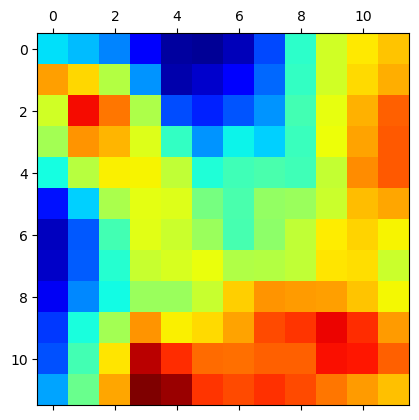

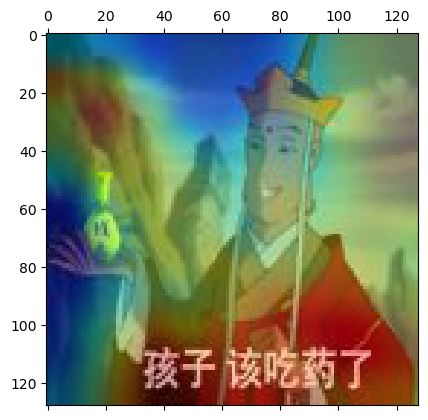

In [25]:
heatmap_1 = heatmap

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

print(heatmap_1)

heatmap_1 = np.uint8(255 * heatmap_1)

print(heatmap_1)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap_1]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)

save_path = "./heat_map/jet20230302t2131.jpg"
jet_heatmap.save(save_path)
plt.matshow(jet_heatmap)

jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0]))

save_path = "./heat_map/jet_sized20230302t2131.jpg"
jet_heatmap.save(save_path)

jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.5 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
plt.matshow(superimposed_img)
save_path = "./heat_map/20230302t2131.jpg"
superimposed_img.save(save_path)
print('1')